# Hierarchical Bayesian Ranking

As the title suggests, this post will examine how to use bayesian models for ranking. As I've been on a kick with the MLB statcast data we'll use this technique to create a ranked list of professional baseball teams.

# Background

In this section we'll briefly discuss bayesian models and ranking. If you are already familiar with both of these topics you can skip this section.

First, let's cover ranking. There are three basic steps to ranking

1. Identify the "items" you wish to rank. This could be any discrete set: baseball teams, baseball players, etc.
2. Fit a model that uses the "item" you wish to rank as a feature to predict something you care about.
3. Extract and use the corresponding model parameters to rank the "items"

For example you might fit a simple linear regression that predicts how much an item will sell where one of the model's features is one of a list of vendors that will market your item. After fitting your model you can inspect the coefficient for each vendor. Since these coefficients come from a linear model, a larger coefficient implies a larger predicted selling price. Thus we can use these coefficients to rank the vendors.

Hierarchical Bayesian Ranking then is just a catchy phrase that means parameters from a [hierarchical bayesian model](https://en.wikipedia.org/wiki/Bayesian_hierarchical_modeling) are used to rank the items. One of the advantages of using a bayesian model is that we can include a measure of variance or *uncertainty* in our rankings. Depending on how the model is defined you may also be able to make other interesting inferences from additional model paramters.

# Acknowledgement

This post was particulary inspired by a few of Andrew Gelman's blog posts in which he [ranked world cup teams](https://andrewgelman.com/2014/07/15/stan-world-cup-update/). You can find a Python implementation of his world cup model on my [githup repo](https://github.com/dantegates/world-cup/blob/master/World%20cup.ipynb). The model in this post bears some resemblance to Gelman's world cup model with a few differences noted here

- Gelman models the difference in goals scored by each team in a given game whereas we'll model the number of wins a team earns in a series. Thus our response variables belong to different distributions.
- Gelman uses [FiveThirtyEight](https://fivethirtyeight.com/) soccer rankings in his model and we'll use FiveThirtyEight's published [Elo](https://en.wikipedia.org/wiki/Elo_rating_system) scores of MLB teams. However the interpretation of the soccer ratings vs the Elo scores are different.

# The model

Now that we've covered all the preliminaries let's go over the model. We will model how many wins one team has over another across the entire 2018 season to date.

Each team's "ability" (which is simply a score the model will learns that represents a team's ability to win games, this is the value we will use to rank the teams) is modeled as follows. The distribution of the team abilities depends on two priors: one for the standard deviation and another which is a coefficient applied to a scaled version of the team's Elo score. This is a similar set up to Gelman's world cup analysis, however the key difference is that gelman's soccer rankings were determined before the world cup was played and the MLB Elo scores are determined from the data we are fitting the model too. Thus the interpretation is different.

The wins are modeled as a [binomial distribution](https://en.wikipedia.org/wiki/Binomial_distribution) where the number of games one team has played against another is fixed (that's part of the outcome we've observed) and the success parameter of the binomial distribution is modeled as a [Dirichlet distribution](https://en.wikipedia.org/wiki/Dirichlet_distribution). Roughly following the notation in the previous link the Dirichlet distribution is

$$
(X_{1}, \ldots, X_{n})\sim Dir(\alpha_{1}, \ldots, \alpha_{n}), \alpha\in\mathbb{R_{>0}}
$$
where
$$
P(X_{i}) = \frac{\alpha_{i}}{\sum_{1}^{n}{\alpha_{i}}}
$$

We define the parameters of the Dirichlet distribution as follows the ability of the home team plus a parameter that represents the home team's advantage and the away teams ability. From the equations above we see that teams with greater abilities will have a higher probability of winning which is a suitable design to allow us to rank the teams based on this parameter.

`pymc3` does have a class for the Dirichlet distribution but I couldn't quite get it to work so I simply implemented it in theano. Note that the parameters of the dirichlet distribution must be greater than zero which means we have to choose priors that support this (or at least make it very unlikely for that to happen).

You can find the data pull for this post [here CHANGE THIS](). Also from this point on a lot of useful information about the code or model fit for the sake of brevity. However, if you want, you can the missing pieces in this [notebook FIX THIS LINK]().

Let's take a look at the first few rows of data.

In [55]:
df.head()

,home_team,home_team_id,away_team,away_team_id,home_team_win,away_team_win,total_games
0,ARI,0,ATL,1,1,3,4
1,ARI,0,CHC,29,1,2,3
2,ARI,0,CIN,13,2,1,3
3,ARI,0,COL,28,3,3,6
4,ARI,0,HOU,15,1,1,2


And now the pym3 model definition.

In [56]:
import theano.tensor as T
import pymc3 as pm

n_teams = len(df.home_team_id.unique())
n_games = len(dd)
n_matchups = np.array([dd.total_games, dd.total_games]).T

team_rankings = {r.team_id: r.score for _, r in rankings.iterrows()}
# convert to array for convenient indexing
team_rankings_arr = np.array([team_rankings[id_] for id_ in team_ids.values()])

home_team_id = dd.home_team_id
away_team_id = dd.away_team_id

observed_wins = dd[['home_team_win', 'away_team_win']]

def dirichlet(a):
    # reshaping for broadcasting
    sum_ = T.sum(a, axis=1).reshape((1, -1)).T
    return a / sum_

with pm.Model() as model:
    b = pm.HalfNormal('b', 1)
    team_abilities_sigma = pm.Uniform('team_abilities_sigma', 0, 2)
    team_abilities = pm.Normal('team_abilities', b*team_rankings_arr, team_abilities_sigma, shape=n_teams)
    home_field_advantage = pm.Normal('home_field_advantage', 0, 1, shape=n_teams)
    home_team_ability = team_abilities[home_team_id] + home_field_advantage[home_team_id]
    away_team_ability = team_abilities[away_team_id]

    matchups = T.stack([home_team_ability, away_team_ability]).T
    prob_winners = pm.Deterministic('prob_winners', dirichlet(matchups))
    p = pm.Binomial('p', n=n_matchups, p=prob_winners, shape=(n_games, 2), observed=observed_wins)

    trace = pm.sample(10_000, model=model)

/Users/dgates/venvs/py3/lib/python3.6/site-packages/theano/tensor/subtensor.py:2190: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [home_field_advantage, team_abilities, team_abilities_sigma, b]
Sampling 2 chains: 100%|██████████| 21000/21000 [03:15<00:00, 107.36draws/s]
The number of effective samples is smaller than 10% for some parameters.


Now that we've fit the model we can extract the posterior probabilities of the teams abilities and rank them. The following plot shows the estimated team abilities with their variance sorted by their Elo scores.

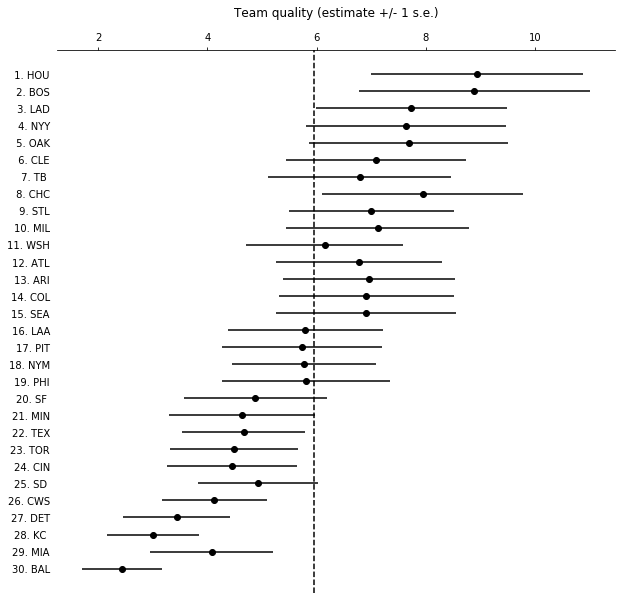

In [77]:
import matplotlib.pyplot as plt
import seaborn as sns

center_line = np.mean(estimated_abilities)
values = list(reversed(estimated_abilities))
labels = list(reversed([team_id_lookup[i] for i in range(n_teams)]))
errors = list(reversed(estimated_abilities_error))

tmp = sorted(zip(values, labels, errors), key=lambda x: rankings.set_index('team').loc[x[1], 'score'])
values, labels, errors = zip(*tmp)
labels = [f'{n_teams-i:2}. {L:3}' for i, L in enumerate(labels)]

fig, ax = plt.subplots(figsize=(10, 10))

# remove borders
sns.despine(left=True, bottom=True, top=False)

# plot error bars
ax.errorbar(values, range(len(labels)), xerr=errors, fmt='o', color='k')

# label the y-adxis
plt.yticks(np.arange(len(labels)))
locs, _ = plt.yticks()
plt.yticks(locs, labels)
plt.tick_params(axis='y', which='both', left=False)

# give it a reference line
ax.axvline(center_line, linestyle='--', color='k')

# Move x axis to top
ax.xaxis.tick_top()

# polish it off with a title
_ = ax.set_title('Team quality (estimate +/- 1 s.e.)', y=1.05)

We can also sample from the posterior to get simulate the outcome of various matchups. For example if the best team in the league played the worst team.

In [64]:
simulate_outcome('BOS', 'BAL')

(0.9992, 0.0008000000000000229)

Or the probability that the Phillies will be the Mets at home and on the road.

In [66]:
simulate_outcome('PHI', 'NYM')

(0.602, 0.398)

In [67]:
simulate_outcome('NYM', 'PHI')

(0.3029, 0.6971)

Lastly we'll sample from the posterior to get bounds on the estimated number of wins the Phillies will earn against each team they've faced this year. The errors are large enough that this plot isn't very informative but it does give us a good idea that we have a proper fit.

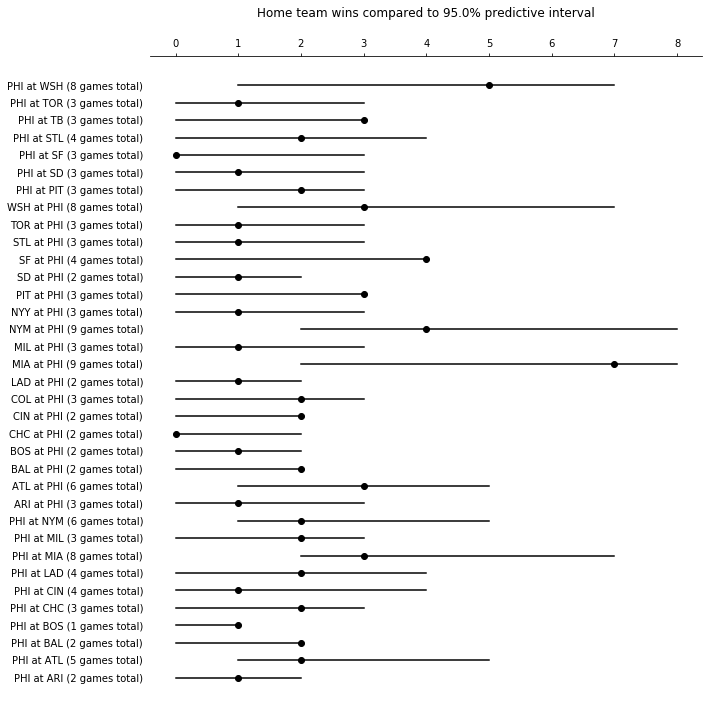

In [84]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize=(10, 10))

# remove borders
sns.despine(left=True, bottom=True, top=False)

# plot actual outcome
wins = np.where(d_eval.is_home, d_eval.home_team_win, d_eval.away_team_win)
ax.scatter(wins, range(len(labels)), color='k')

# plot error bars
for idx, (_, rec) in enumerate(d_eval.iterrows()):
    if rec.is_home:
        low, high = rec.home_team_lower_bound, rec.home_team_upper_bound
    else:
        low, high = rec.away_team_lower_bound, rec.away_team_upper_bound
    ax.plot([low, high], [idx, idx], color='k')

# label the y-adxis
plt.yticks(np.arange(len(labels)))
locs, _ = plt.yticks()
plt.yticks(locs, labels)
plt.tick_params(axis='y', which='both', left=False)

# Move x axis to top
ax.xaxis.tick_top()

# polish it off with a title
_ = ax.set_title(f'Home team wins compared to {100*p}% predictive interval', y=1.05)

plt.tight_layout()